# Debug

In [ ]:
import numpy as np
from sklearn.linear_model import Lasso
import utils
from CoRT_builder import CoRT
import importlib
import matplotlib.pyplot as plt
import oc
importlib.reload(utils)
importlib.reload(oc)

n_target = 100
n_source = 50
p = 100
K = 10
Ka = 8
h = 30
lamda = 0.1
s_vector = [0] * 10
T = 5
s = len(s_vector)
CoRT_model = CoRT(alpha=lamda)
p_values = []
iteration = 100

CoRT_model = CoRT(alpha=lamda)

for iter in range(iteration):
    target_data, source_data = CoRT_model.gen_data(n_target, n_source, p, K, Ka, h, s_vector, s, "AR")
    similar_source_index = CoRT_model.find_similar_source(n_target, K, target_data, source_data, T=T, verbose=False)
    X_combined, y_combined = CoRT_model.prepare_CoRT_data(similar_source_index, source_data, target_data)

    model = Lasso(alpha=lamda, fit_intercept=False, tol=1e-10, max_iter=10000000)
    model.fit(X_combined, y_combined.ravel())
    beta_hat_target = model.coef_[-p:]

    active_indices = np.array([i for i, b in enumerate(beta_hat_target) if b != 0])
    initial_active_indices = active_indices

    if len(active_indices) == 0:
        print(f"Iteration {iter}: Lasso selected no features. Skipping.")
        continue

    j = np.random.choice(len(active_indices))

    X_target = target_data["X"]
    y_target = target_data["y"]
    X_active, X_inactive = utils.get_active_X(beta_hat_target, X_target)

    etaj, etajTy = utils.construct_test_statistic(y_target, j, X_active)

    Sigma = np.eye(n_target)
    b_global = Sigma @ etaj @ np.linalg.pinv(etaj.T @ Sigma @ etaj)
    a_global = (Sigma - b_global @ etaj.T) @ y_target

    folds = utils.split_target(T, X_target, y_target, n_target)

    z_k = -20
    z_max = 20

    target_data_current = {"X": X_target, "y": a_global + z_k * b_global}
    similar_source_current = utils.find_similar_source(z_k, a_global, b_global, lamda,  n_target, K, target_data_current, source_data, T=T, verbose=False)
    X_combined_new, y_combined_new = CoRT_model.prepare_CoRT_data(similar_source_current, source_data, target_data_current)
    L_CoRT, R_CoRT, Az = oc.get_Z_CoRT(X_combined_new, similar_source_current, lamda, a_global, b_global, source_data, z_k)

    offset = p * len(similar_source_index)
    Az_target_only = np.array([idx - offset for idx in Az if idx >= offset])
    z_list = [z_k]
    Az_list = []

    print("="*50)
    print("Initialization")
    print(f"z_obs: {etajTy}")
    print(f"Initial similar source index: {similar_source_index}")
    print(f"Active indices: {Az}")
    print("="*50)


    step_count = 0
    matched_active_set = None

    while z_k < z_max:
        step_count += 1
        print(f"zk at step {step_count}: {z_k}")

        L_train, R_train = oc.get_Z_train(z_k, folds, source_data, a_global, b_global, lamda, K, T)
        L_val, R_val = oc.get_Z_val(folds, T, K, a_global, b_global, z_k, lamda, source_data)

        target_data_current = {"X": X_target, "y": a_global + z_k * b_global}
        current_similar_source_index = utils.find_similar_source(z_k, a_global, b_global, lamda, n_target, K, target_data_current, source_data, T)
        X_combined_current, y_combined_current = CoRT_model.prepare_CoRT_data(current_similar_source_index, source_data, target_data_current)
        L_CoRT, R_CoRT, current_active_set_global = oc.get_Z_CoRT(X_combined_current, current_similar_source_index, lamda, a_global, b_global, source_data, z_k)

        L_final, R_final = oc.combine_Z(L_train, R_train, L_val, R_val, L_CoRT, R_CoRT)

        stopper = None
        if R_final == R_train: 
            stopper = "TRAIN"
        elif R_final == R_val: 
            stopper = "VAL"
        else: 
            stopper = "CORT"

        current_offset = p * len(current_similar_source_index)
        current_active_set_target = np.array([idx - current_offset for idx in current_active_set_global if idx >= current_offset])
        Az_list.append(current_active_set_target)

        print(f"current_similar_source_index: {current_similar_source_index}")
        print(f"current_active_set_target: {current_active_set_target}")

        if np.array_equal(initial_active_indices, current_active_set_target): 
            print(f" -> MATCH! Active set matches Initial at zk {z_k:.5f}")

        print(f" R_train: {R_train:.5f}")
        print(f" R_val:   {R_val:.5f}")
        print(f" R_CoRT:  {R_CoRT:.5f}")
        print(f" STOPPER: {stopper} (Next jump to {R_final:.5f})")

        z_next = max(R_final, z_k) + 1e-5

        if z_next <= z_k:
            print(" WARNING: Stuck! Forcing jump.")
            z_next = z_k + 0.01

        z_k = z_next
        z_list.append(z_k)

        print("\n\n")

        if z_k >= z_max: 
            print("Finish")
            break

    z_interval = []
    for i in range(len(Az_list)):
        # Use safe comparison for mixed types
        if np.array_equal(active_indices, Az_list[i]):
                z_interval.append([z_list[i], z_list[i+1]]) 

    # Merge intervals
    new_z_interval = []
    for interval in z_interval:
        if len(new_z_interval) == 0:
            new_z_interval.append(interval)
        else:
            dif = abs(interval[0] - new_z_interval[-1][1])
            if dif < 0.001:
                new_z_interval[-1][1] = interval[1]
            else:
                new_z_interval.append(interval)
    z_interval = new_z_interval
    
    print(f"z_obs: {etajTy}")
    print(f"{len(z_interval)} intervals found: {z_interval}")

    is_z_obs_in_intervals = False
    for i, interval in enumerate(z_interval):
        if interval[0] <= etajTy <= interval[1]:
            is_z_obs_in_intervals = True
            break

    if is_z_obs_in_intervals == False:
        print(f" WARNING: z_obs is not in the intervals:\nz_obs: {etajTy}\nIntervals:{z_interval}")
    else: 
        print("z_obs is in the intervals")

    p_value = utils.pivot(active_indices, Az_list, z_list, etaj, etajTy, 0, Sigma)
    p_values.append(p_value)
    print(f"p-value: {p_value}")

plt.hist(p_values, density=True, bins=30, edgecolor='black')
plt.title("p-value Distribution")
plt.xlabel("p-value")
plt.ylabel('Density')
plt.tight_layout()
plt.show()

Initialization
z_obs: -0.2185703157336474
Initial similar source index: [0]
Active indices: [0, 1, 5, 11, 12, 14, 16, 17, 26, 35, 38, 42, 44, 45, 46, 48, 50, 51, 56, 57, 61, 62, 64, 67, 68, 71, 82, 83, 84, 85, 86, 91, 93, 95]
zk at step 1: -20
current_similar_source_index: []
current_active_set_target: [ 0  1  5 11 12 14 16 17 26 35 38 42 44 45 46 48 50 51 56 57 61 62 64 67
 68 71 82 83 84 85 86 91 93 95]
 R_train: -19.99457
 R_val:   inf
 R_CoRT:  -17.57254
 STOPPER: TRAIN (Next jump to -19.99457)



zk at step 2: -19.99456748944186
current_similar_source_index: []
current_active_set_target: [ 0  1  5 11 12 14 16 17 26 35 38 42 44 45 46 48 50 51 56 57 61 62 64 67
 68 71 82 83 84 85 86 91 93 95]
 R_train: -19.98146
 R_val:   inf
 R_CoRT:  -17.57254
 STOPPER: TRAIN (Next jump to -19.98146)



zk at step 3: -19.981461057615558
current_similar_source_index: []
current_active_set_target: [ 0  1  5 11 12 14 16 17 26 35 38 42 44 45 46 48 50 51 56 57 61 62 64 67
 68 71 82 83 84 85 86 91 93 95

KeyboardInterrupt: 

# Test uniform

In [ ]:
import numpy as np
from sklearn.linear_model import Lasso
import utils
from CoRT_builder import CoRT
import importlib
import matplotlib.pyplot as plt
import oc
importlib.reload(utils)
importlib.reload(oc)

n_target = 30
n_source = 10
p = 5
K = 3
Ka = 1
h = 30
lamda = 0.1
s_vector = [0]
T = 3
s = len(s_vector)
CoRT_model = CoRT(alpha=lamda)
p_values = []
iteration = 800

for i in range(iteration):
    target_data, source_data = CoRT_model.gen_data(n_target, n_source, p, K, Ka, h, s_vector, s, "AR")
    similar_source_index = CoRT_model.find_similar_source(n_target, K, target_data, source_data, T=T, verbose=False)
    X_combined, y_combined = CoRT_model.prepare_CoRT_data(similar_source_index, source_data, target_data)

    model = Lasso(alpha=lamda, fit_intercept=False, tol=1e-10, max_iter=10000000)
    model.fit(X_combined, y_combined.ravel())
    beta_hat_target = model.coef_[-p:]

    active_indices = np.array([i for i, b in enumerate(beta_hat_target) if b != 0])
    initial_active_indices = active_indices

    if len(active_indices) == 0:
        print(f"Iteration {iter}: Lasso selected no features. Skipping.")
        continue


    j = np.random.choice(len(active_indices))

    X_target = target_data["X"]
    y_target = target_data["y"]
    X_active, X_inactive = utils.get_active_X(beta_hat_target, X_target)

    etaj, etajTy = utils.construct_test_statistic(y_target, j, X_active)

    Sigma = np.eye(n_target)
    b_global = Sigma @ etaj @ np.linalg.pinv(etaj.T @ Sigma @ etaj)
    a_global = (Sigma - b_global @ etaj.T) @ y_target

    folds = utils.split_target(T, X_target, y_target, n_target)

    z_k = -20
    z_max = 20

    target_data_current = {"X": X_target, "y": a_global + z_k * b_global}
    similar_source_current = utils.find_similar_source(z_k, a_global, b_global, lamda,  n_target, K, target_data_current, source_data, T=T, verbose=False)
    X_combined_new, y_combined_new = CoRT_model.prepare_CoRT_data(similar_source_current, source_data, target_data_current)
    L_CoRT, R_CoRT, Az = oc.get_Z_CoRT(X_combined_new, similar_source_current, lamda, a_global, b_global, source_data, z_k)

    offset = p * len(similar_source_index)
    Az_target_only = np.array([idx - offset for idx in Az if idx >= offset])
    z_list = [z_k]
    Az_list = []

    # print("="*50)
    # print("Initialization")
    # print(f"z_obs: {etajTy}")
    # print(f"Initial similar source index: {similar_source_index}")
    # print(f"Active indices: {Az}")
    # print("="*50)


    step_count = 0
    matched_active_set = None

    while z_k < z_max:
        # step_count += 1
        # print(f"zk at step {step_count}: {z_k}")

        L_train, R_train = oc.get_Z_train(z_k, folds, source_data, a_global, b_global, lamda, K, T)
        L_val, R_val = oc.get_Z_val(folds, T, K, a_global, b_global, z_k, lamda, source_data)

        target_data_current = {"X": X_target, "y": a_global + z_k * b_global}
        current_similar_source_index = utils.find_similar_source(z_k, a_global, b_global, lamda, n_target, K, target_data_current, source_data, T)
        X_combined_current, y_combined_current = CoRT_model.prepare_CoRT_data(current_similar_source_index, source_data, target_data_current)
        L_CoRT, R_CoRT, current_active_set_global = oc.get_Z_CoRT(X_combined_current, current_similar_source_index, lamda, a_global, b_global, source_data, z_k)

        L_final, R_final = oc.combine_Z(L_train, R_train, L_val, R_val, L_CoRT, R_CoRT)

        # stopper = None
        # if R_final == R_train: 
        #     stopper = "TRAIN"
        # elif R_final == R_val: 
        #     stopper = "VAL"
        # else: 
        #     stopper = "CORT"

        current_offset = p * len(current_similar_source_index)
        current_active_set_target = np.array([idx - current_offset for idx in current_active_set_global if idx >= current_offset])
        Az_list.append(current_active_set_target)

        # print(f"current_similar_source_index: {current_similar_source_index}")
        # print(f"current_active_set_target: {current_active_set_target}")

        # if np.array_equal(initial_active_indices, current_active_set_target): 
        #     print(f" -> MATCH! Active set matches Initial at zk {z_k:.5f}")

        # print(f" R_train: {R_train:.5f}")
        # print(f" R_val:   {R_val:.5f}")
        # print(f" R_CoRT:  {R_CoRT:.5f}")
        # print(f" STOPPER: {stopper} (Next jump to {R_final:.5f})")

        z_next = max(R_final, z_k) + 1e-5

        if z_next <= z_k:
            print(" WARNING: Stuck! Forcing jump.")
            z_next = z_k + 0.01

        z_k = z_next
        z_list.append(z_k)

        # print("\n\n")

        if z_k >= z_max: 
            # print("Finish")
            break

    pivot_value = utils.pivot(active_indices, Az_list, z_list, etaj, etajTy, 0, Sigma)
    p_values.append(pivot_value)
    print(f"Processing {i, pivot_value}")

plt.hist(p_values, density=True, bins=30, edgecolor='black')
plt.title("p-value Distribution")
plt.xlabel("p-value")
plt.ylabel('Density')
plt.tight_layout()
plt.show()

Processing (0, 0.4990415647835344)
Processing (1, 0.22610677854479905)
Processing (2, 0.21410953958195125)
Iteration <built-in function iter>: Lasso selected no features. Skipping.
Processing (4, 0.04839272885631286)
Processing (5, 0.966839392277248)
Processing (6, 0.4233345322858897)
Processing (7, 0.607391984638932)
Processing (8, 0.8219802215238571)
Processing (9, 0.765246958824841)
Processing (10, 0.14401093321328962)
Processing (11, 0.0990284956470742)
Processing (12, 0.5904436435398568)
Processing (13, 0.7264182233718806)
Processing (14, 0.5755095859321748)
Processing (15, 0.27950104976409396)
Processing (16, 0.7063895857315412)
Processing (17, 0.29323594441093626)
Processing (18, 0.6663052575675225)
Processing (19, 0.7777370694363441)
Processing (20, 0.728549044630238)
Processing (21, 0.2615782533638797)
Processing (22, 0.7152378407348209)
Processing (23, 0.5761107477425313)
Processing (24, 0.007938592540395849)
Processing (25, 0.31039026241319173)
Processing (26, 0.688414832398

KeyboardInterrupt: 

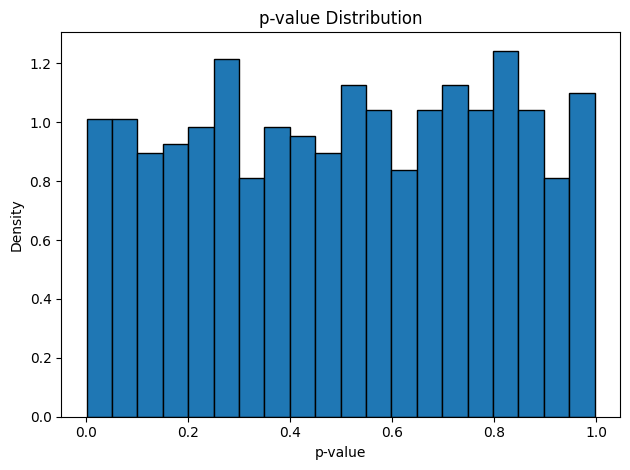

In [69]:
new_p_values = prev_p_values.extend(p_values)

plt.hist(p_values, density=True, bins=20, edgecolor='black')
plt.title("p-value Distribution")
plt.xlabel("p-value")
plt.ylabel('Density')
plt.tight_layout()
plt.show()

# Test FPR, TPR

In [ ]:
import numpy as np
from sklearn.linear_model import Lasso
import utils
from CoRT_builder import CoRT
import importlib
import matplotlib.pyplot as plt
import oc
importlib.reload(utils)
importlib.reload(oc)

n_target = 30
n_source = 10
p = 5
K = 3
Ka = 1
h = 30
lamda = 0.1
s_vector = [1]
T = 3
s = len(s_vector)
CoRT_model = CoRT(alpha=lamda)
results_storage = []
alpha = 0.05
iteration = 800

for i in range(iteration):
    target_data, source_data = CoRT_model.gen_data(n_target, n_source, p, K, Ka, h, s_vector, s, "AR")
    similar_source_index = CoRT_model.find_similar_source(n_target, K, target_data, source_data, T=T, verbose=False)
    X_combined, y_combined = CoRT_model.prepare_CoRT_data(similar_source_index, source_data, target_data)

    model = Lasso(alpha=lamda, fit_intercept=False, tol=1e-10, max_iter=10000000)
    model.fit(X_combined, y_combined.ravel())
    beta_hat_target = model.coef_[-p:]

    active_indices = np.array([i for i, b in enumerate(beta_hat_target) if b != 0])
    initial_active_indices = active_indices

    if len(active_indices) == 0:
        print(f"Iteration {iter}: Lasso selected no features. Skipping.")
        continue

    j = np.random.choice(len(active_indices))

    selected_feature_index = active_indices[j]

    X_target = target_data["X"]
    y_target = target_data["y"]
    X_active, X_inactive = utils.get_active_X(beta_hat_target, X_target)

    etaj, etajTy = utils.construct_test_statistic(y_target, j, X_active)

    Sigma = np.eye(n_target)
    b_global = Sigma @ etaj @ np.linalg.pinv(etaj.T @ Sigma @ etaj)
    a_global = (Sigma - b_global @ etaj.T) @ y_target

    folds = utils.split_target(T, X_target, y_target, n_target)

    z_k = -20
    z_max = 20

    target_data_current = {"X": X_target, "y": a_global + z_k * b_global}
    similar_source_current = utils.find_similar_source(z_k, a_global, b_global, lamda,  n_target, K, target_data_current, source_data, T=T, verbose=False)
    X_combined_new, y_combined_new = CoRT_model.prepare_CoRT_data(similar_source_current, source_data, target_data_current)
    L_CoRT, R_CoRT, Az = oc.get_Z_CoRT(X_combined_new, similar_source_current, lamda, a_global, b_global, source_data, z_k)

    offset = p * len(similar_source_index)
    Az_target_only = np.array([idx - offset for idx in Az if idx >= offset])
    z_list = [z_k]
    Az_list = []

    # print("="*50)
    # print("Initialization")
    # print(f"z_obs: {etajTy}")
    # print(f"Initial similar source index: {similar_source_index}")
    # print(f"Active indices: {Az}")
    # print("="*50)

    step_count = 0
    matched_active_set = None

    while z_k < z_max:
        # step_count += 1
        # print(f"zk at step {step_count}: {z_k}")

        L_train, R_train = oc.get_Z_train(z_k, folds, source_data, a_global, b_global, lamda, K, T)
        L_val, R_val = oc.get_Z_val(folds, T, K, a_global, b_global, z_k, lamda, source_data)

        target_data_current = {"X": X_target, "y": a_global + z_k * b_global}
        current_similar_source_index = utils.find_similar_source(z_k, a_global, b_global, lamda, n_target, K, target_data_current, source_data, T)
        X_combined_current, y_combined_current = CoRT_model.prepare_CoRT_data(current_similar_source_index, source_data, target_data_current)
        L_CoRT, R_CoRT, current_active_set_global = oc.get_Z_CoRT(X_combined_current, current_similar_source_index, lamda, a_global, b_global, source_data, z_k)

        L_final, R_final = oc.combine_Z(L_train, R_train, L_val, R_val, L_CoRT, R_CoRT)

        # stopper = None
        # if R_final == R_train: 
        #     stopper = "TRAIN"
        # elif R_final == R_val: 
        #     stopper = "VAL"
        # else: 
        #     stopper = "CORT"

        current_offset = p * len(current_similar_source_index)
        current_active_set_target = np.array([idx - current_offset for idx in current_active_set_global if idx >= current_offset])
        Az_list.append(current_active_set_target)

        # print(f"current_similar_source_index: {current_similar_source_index}")
        # print(f"current_active_set_target: {current_active_set_target}")

        # if np.array_equal(initial_active_indices, current_active_set_target): 
        #     print(f" -> MATCH! Active set matches Initial at zk {z_k:.5f}")

        # print(f" R_train: {R_train:.5f}")
        # print(f" R_val:   {R_val:.5f}")
        # print(f" R_CoRT:  {R_CoRT:.5f}")
        # print(f" STOPPER: {stopper} (Next jump to {R_final:.5f})")

        z_next = max(R_final, z_k) + 1e-5

        if z_next <= z_k:
            print(" WARNING: Stuck! Forcing jump.")
            z_next = z_k + 0.01

        z_k = z_next
        z_list.append(z_k)

        # print("\n\n")

        if z_k >= z_max: 
            # print("Finish")
            break

    pivot_value = utils.pivot(active_indices, Az_list, z_list, etaj, etajTy, 0, Sigma)

    is_signal = (selected_feature_index < s) 
    results_storage.append({
        "p_value": pivot_value,
        "is_signal": is_signal,
        "feature_idx": selected_feature_index
    })
    #print(f"Processing {i, is_signal}")
    
is_signal_cases = [r for r in results_storage if r['is_signal']]
not_signal_cases = [r for r in results_storage if not r['is_signal']]

false_positives = sum(1 for c in not_signal_cases if c['p_value'] <= alpha)
fpr = false_positives / len(not_signal_cases)
print(f"FPR: {fpr:.4f} (Target: {alpha})")

true_positives = sum(1 for r in is_signal_cases if r['p_value'] <= alpha)
tpr = true_positives / len(is_signal_cases)
print(f"TPR: {tpr:.4f}")

FPR (Type I Error): 0.0413 (Target: 0.05)
TPR (Power): 0.9008
